In [1]:
from pandas_datareader import data as pdr 
from datetime import date
import yfinance as yf 
yf.pdr_override()
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt 
import math
import quandl
import numpy as np
from sklearn import preprocessing
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
%matplotlib qt

In [2]:
ticker_sp = '^GSPC'
ticker_gold = 'GC=F'
ticker_oil = 'CL=F'
ticker_dax = '^GDAXI'
ticker_nikkei = '^N225'
ticker_ftse = '^FTSE'
ticker_shanghai = '000001.SS'

auth_tok = "Nv1rJgRR7u88iz_dg7Y6"

end_date = "2020-09-1"
start_date = "1970-01-02"

In [3]:
def getGOLDData ():
    # Contains only price from 1975 onwards
    data = quandl.get("CHRIS/CME_GC1", trim_start = start_date, trim_end = end_date, authtoken=auth_tok)
    data = data[['Last']]
    data.columns = ["GOLD Adj Close"]
    return data

def getSPData():
    # Contains price from 1970 onwards
    data = pdr.get_data_yahoo(ticker_sp, start=start_date, end=end_date)
    data = data[data.columns[4:5]] 
    data.columns = ["SP500 Adj Close"]
    return data

def getDAXData():
    # Contains price from 1988 onwards
    data = pdr.get_data_yahoo(ticker_dax, start=start_date, end=end_date)
    data = data[data.columns[4:5]]
    data.columns = ["DAX Adj Close"]
    return data


def getOILData():
    # Contains only price FROM 1984 onwards
    data = quandl.get("CHRIS/CME_CL1", trim_start = start_date, trim_end = end_date, authtoken=auth_tok)
    data = data[["Last"]]
    data.columns=["OIL Adj Close"]
    return data


def getNIKKEIData():
    # Contains only price from 1970 onwards
    data = pdr.get_data_yahoo(ticker_nikkei, start=start_date, end=end_date)
    data = data[data.columns[4:5]] 
    data.columns = ["NIKKEI Adj Close"]
    return data


def getFTSEData():
    # Contains price from 1984 onwards
    data = pdr.get_data_yahoo(ticker_ftse, start=start_date, end=end_date)
    data = data[data.columns[4:5]] 
    data.columns = ["FTSE Adj Close"]
    return data

def getSHANGHAIData():
    # Contains only price from 1997
    data = pdr.get_data_yahoo(ticker_shanghai, start=start_date, end=end_date)
    data = data[data.columns[4:5]] 
    data.columns = ["SHANGHAI Adj Close"]
    return data

In [4]:
def combineData():
    allData = [getSPData(), getDAXData(), getFTSEData(), getGOLDData(), getOILData()]
    mergedData = pd.concat(allData, axis = 1)
    cleanData = mergedData.dropna()
    return cleanData

In [52]:
data = combineData()

FUTURE_TO_PREDICT = 1 # Number of days into the future we want to predict

data['Future'] = data['SP500 Adj Close'].shift(-FUTURE_TO_PREDICT)

data.dropna(inplace=True)

def buy_or_sell (current, future):
    if (future > current):
        return 1
    else:
        return 0
    
data['Target'] = list(map(buy_or_sell, data['SP500 Adj Close'], data['Future']))

NUMBER_OF_DATA_POINTS = len(data)
SIZE_TRAINING = int(NUMBER_OF_DATA_POINTS * 0.85)
SIZE_TESTING  = NUMBER_OF_DATA_POINTS - SIZE_TRAINING
print("size of training data: {}".format(SIZE_TRAINING))
print("size of testing data: {}".format(SIZE_TESTING))

data_training = data[:SIZE_TRAINING]
data_testing  = data[SIZE_TRAINING:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
size of training data: 6723
size of testing data: 1187


In [53]:
print(data_training)

            SP500 Adj Close  DAX Adj Close  FTSE Adj Close  GOLD Adj Close  \
Date                                                                         
1987-12-30       247.860001    1005.190002     1759.800049           485.5   
1988-01-04       255.940002     956.489990     1713.900024           480.5   
1988-01-05       258.630005     996.099976     1789.599976           483.2   
1988-01-06       258.890015    1006.010010     1787.099976           485.3   
1988-01-07       261.070007    1014.469971     1787.199951           483.1   
...                     ...            ...             ...             ...   
2015-08-25      1867.609985   10128.120117     6081.299805          1139.7   
2015-08-26      1940.510010    9997.429688     5979.200195          1124.5   
2015-08-27      1987.660034   10315.620117     6192.000000          1123.4   
2015-08-28      1988.869995   10298.530273     6247.899902          1132.8   
2015-09-01      1913.849976   10015.570312     6058.500000      

In [54]:
def process_data(data):
    data.drop("Future", axis = 1, inplace = True)  # Drop the future column so that the NN doesn't have access to the future
    
    for column in data.columns:  # Normalize the columns
        if column != "Target":   # We only want to normalize the other columns
            data[column] = data[column].pct_change()   # Normalization by percent change
            data.dropna(inplace = True)
            data[column] = preprocessing.scale(data[column].values)    # First testing without scaling
    
    data.dropna(inplace = True)

    sequential_data = []
    sequence_length = 15 # Number of days into the past we are using to make a prediction
    
    for day in range (len(data)-sequence_length+1):
        
        sequence = []
        
        for future_day in range (sequence_length):
            sequence.append(data.iloc[day + future_day][:-1])
        
        buy_or_sell = data.iloc[day + sequence_length - 1][-1]
        
        sequential_data.append([sequence, buy_or_sell])
    
    random.shuffle(sequential_data)
    
    buy_sequences  = []
    sell_sequences = []
    
    for sequence, target in sequential_data:
        if target == 1:
            buy_sequences.append([sequence, target])
        elif target == 0:
            sell_sequences.append([sequence, target])
            
    print("{} buys".format(len(buy_sequences)))
    print("{} sells".format(len(sell_sequences)))
    
    random.shuffle(buy_sequences)
    random.shuffle(sell_sequences)
    
    max_size = min(len(buy_sequences), len(sell_sequences))
    
    print("reduced to {} buys and sells".format(max_size))
    
    buy_sequences  = buy_sequences[:max_size]
    sell_sequences = sell_sequences[:max_size]
    
    sequential_data = buy_sequences + sell_sequences
    random.shuffle(sequential_data)
    
    x = []
    y = []
    
    for sequence, target in sequential_data:
        x.append(sequence)
        y.append(target)
        
    x = np.array(x)
    y = np.array(y)
    
    return x,y

In [55]:
x_train, y_train = process_data(data_training)
x_test, y_test   = process_data(data_testing)

3597 buys
3107 sells
reduced to 3107 buys and sells
651 buys
517 sells
reduced to 517 buys and sells


In [135]:
model = Sequential()

LSTM_LAYERS = 3
LSTM_REPRESENTATION = 32
DENSE_REPRESENTATION = 16
DROPOUT = 0.2
LEARNING_RATE = 0.00001
BATCH_SIZE = 32


model.add(LSTM(LSTM_REPRESENTATION, activation = 'relu', input_shape = (x_train.shape[1:]), return_sequences = True))
model.add(Dropout(DROPOUT))
model.add(BatchNormalization())

model.add(LSTM(LSTM_REPRESENTATION, return_sequences = True))
model.add(Dropout(DROPOUT))
model.add(BatchNormalization())

model.add(LSTM(LSTM_REPRESENTATION))
model.add(Dropout(DROPOUT))
model.add(BatchNormalization())

model.add(Dense(DENSE_REPRESENTATION, activation = 'relu'))
model.add(Dropout(DROPOUT))

model.add(Dense(2, activation = 'softmax'))

In [136]:
opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE, decay = 1e-6)

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = opt,
    metrics = ['accuracy']
)

tensorboard = TensorBoard(log_dir="logs\LSTM-{}-DENSE-{}-LAYERS-{}-DROPOUT-{}-LR-{}-BS-{}-MK-10".format(LSTM_REPRESENTATION, DENSE_REPRESENTATION, LSTM_LAYERS, DROPOUT, LEARNING_RATE, BATCH_SIZE))

In [137]:
history = model.fit(
    x_train, y_train,
    batch_size = BATCH_SIZE,
    epochs = 1200,
    validation_data = (x_test, y_test),
    callbacks=[tensorboard]
)

Train on 6214 samples, validate on 1034 samples
Epoch 1/1200
6214/6214 [==============================] - 13s 2ms/step - loss: 0.8532 - acc: 0.5023 - val_loss: 0.6966 - val_acc: 0.4932
Epoch 2/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.8358 - acc: 0.5126 - val_loss: 0.7189 - val_acc: 0.4855
Epoch 3/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.8277 - acc: 0.5085 - val_loss: 0.7408 - val_acc: 0.4874
Epoch 4/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.8265 - acc: 0.5016 - val_loss: 0.7442 - val_acc: 0.4797
Epoch 5/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.8076 - acc: 0.5076 - val_loss: 0.7404 - val_acc: 0.4894
Epoch 6/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.8216 - acc: 0.4931 - val_loss: 0.7374 - val_acc: 0.4913
Epoch 7/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.8009 - acc: 0.5101 - val_loss: 0.7329 - val_acc: 0.4942

6214/6214 [==============================] - 7s 1ms/step - loss: 0.7330 - acc: 0.4973 - val_loss: 0.7047 - val_acc: 0.4981
Epoch 61/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7313 - acc: 0.5106 - val_loss: 0.7046 - val_acc: 0.4990
Epoch 62/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7279 - acc: 0.5100 - val_loss: 0.7046 - val_acc: 0.5019
Epoch 63/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7275 - acc: 0.5010 - val_loss: 0.7044 - val_acc: 0.5039
Epoch 64/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7273 - acc: 0.5074 - val_loss: 0.7042 - val_acc: 0.5010
Epoch 65/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7304 - acc: 0.4987 - val_loss: 0.7041 - val_acc: 0.4990
Epoch 66/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7280 - acc: 0.5031 - val_loss: 0.7039 - val_acc: 0.5010
Epoch 67/1200
6214/6214 [==============================

Epoch 120/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7085 - acc: 0.5106 - val_loss: 0.6993 - val_acc: 0.5126
Epoch 121/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7075 - acc: 0.5137 - val_loss: 0.6989 - val_acc: 0.5164
Epoch 122/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7060 - acc: 0.5200 - val_loss: 0.6991 - val_acc: 0.5097
Epoch 123/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7107 - acc: 0.5072 - val_loss: 0.6990 - val_acc: 0.5106
Epoch 124/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7066 - acc: 0.5235 - val_loss: 0.6991 - val_acc: 0.5116
Epoch 125/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7044 - acc: 0.5241 - val_loss: 0.6989 - val_acc: 0.5126
Epoch 126/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7048 - acc: 0.5183 - val_loss: 0.6990 - val_acc: 0.5058
Epoch 127/1200
6214/6214 [========

6214/6214 [==============================] - 7s 1ms/step - loss: 0.7012 - acc: 0.5200 - val_loss: 0.6963 - val_acc: 0.4884
Epoch 180/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6979 - acc: 0.5204 - val_loss: 0.6963 - val_acc: 0.4913
Epoch 181/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6996 - acc: 0.5193 - val_loss: 0.6965 - val_acc: 0.4845
Epoch 182/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6989 - acc: 0.5227 - val_loss: 0.6964 - val_acc: 0.4855
Epoch 183/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7007 - acc: 0.5172 - val_loss: 0.6962 - val_acc: 0.4923
Epoch 184/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.7004 - acc: 0.5214 - val_loss: 0.6961 - val_acc: 0.4961
Epoch 185/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.7025 - acc: 0.5164 - val_loss: 0.6961 - val_acc: 0.4932
Epoch 186/1200
6214/6214 [=======================

6214/6214 [==============================] - 6s 1ms/step - loss: 0.6968 - acc: 0.5127 - val_loss: 0.6945 - val_acc: 0.5019
Epoch 239/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6948 - acc: 0.5225 - val_loss: 0.6945 - val_acc: 0.5029
Epoch 240/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6990 - acc: 0.5101 - val_loss: 0.6946 - val_acc: 0.5039
Epoch 241/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6984 - acc: 0.5080 - val_loss: 0.6945 - val_acc: 0.4990
Epoch 242/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6964 - acc: 0.5116 - val_loss: 0.6945 - val_acc: 0.5029
Epoch 243/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6983 - acc: 0.5092 - val_loss: 0.6945 - val_acc: 0.5058
Epoch 244/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6958 - acc: 0.5233 - val_loss: 0.6945 - val_acc: 0.4990
Epoch 245/1200
6214/6214 [=======================

6214/6214 [==============================] - 7s 1ms/step - loss: 0.6945 - acc: 0.5251 - val_loss: 0.6932 - val_acc: 0.5058
Epoch 298/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6950 - acc: 0.5188 - val_loss: 0.6933 - val_acc: 0.5058
Epoch 299/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6920 - acc: 0.5280 - val_loss: 0.6933 - val_acc: 0.5010
Epoch 300/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6934 - acc: 0.5188 - val_loss: 0.6933 - val_acc: 0.5010
Epoch 301/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6952 - acc: 0.5172 - val_loss: 0.6933 - val_acc: 0.5077
Epoch 302/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6929 - acc: 0.5233 - val_loss: 0.6933 - val_acc: 0.4981
Epoch 303/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6922 - acc: 0.5338 - val_loss: 0.6934 - val_acc: 0.5068
Epoch 304/1200
6214/6214 [=======================

6214/6214 [==============================] - 7s 1ms/step - loss: 0.6938 - acc: 0.5145 - val_loss: 0.6927 - val_acc: 0.5097
Epoch 357/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6899 - acc: 0.5346 - val_loss: 0.6929 - val_acc: 0.5039
Epoch 358/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6884 - acc: 0.5341 - val_loss: 0.6929 - val_acc: 0.5097
Epoch 359/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6924 - acc: 0.5232 - val_loss: 0.6928 - val_acc: 0.5155
Epoch 360/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6924 - acc: 0.5262 - val_loss: 0.6928 - val_acc: 0.5145
Epoch 361/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6906 - acc: 0.5280 - val_loss: 0.6927 - val_acc: 0.5126
Epoch 362/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6892 - acc: 0.5264 - val_loss: 0.6926 - val_acc: 0.5145
Epoch 363/1200
6214/6214 [=======================

6214/6214 [==============================] - 7s 1ms/step - loss: 0.6896 - acc: 0.5401 - val_loss: 0.6928 - val_acc: 0.5174
Epoch 416/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6895 - acc: 0.5243 - val_loss: 0.6927 - val_acc: 0.5116
Epoch 417/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6918 - acc: 0.5216 - val_loss: 0.6927 - val_acc: 0.5135
Epoch 418/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6917 - acc: 0.5285 - val_loss: 0.6928 - val_acc: 0.5116
Epoch 419/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6912 - acc: 0.5332 - val_loss: 0.6928 - val_acc: 0.5087
Epoch 420/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6906 - acc: 0.5288 - val_loss: 0.6928 - val_acc: 0.5145
Epoch 421/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6905 - acc: 0.5217 - val_loss: 0.6928 - val_acc: 0.5068
Epoch 422/1200
6214/6214 [=======================

6214/6214 [==============================] - 7s 1ms/step - loss: 0.6892 - acc: 0.5380 - val_loss: 0.6926 - val_acc: 0.5155
Epoch 475/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6911 - acc: 0.5325 - val_loss: 0.6926 - val_acc: 0.5155
Epoch 476/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6919 - acc: 0.5227 - val_loss: 0.6926 - val_acc: 0.5164
Epoch 477/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6902 - acc: 0.5293 - val_loss: 0.6926 - val_acc: 0.5184
Epoch 478/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6885 - acc: 0.5378 - val_loss: 0.6927 - val_acc: 0.5116
Epoch 479/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6868 - acc: 0.5389 - val_loss: 0.6928 - val_acc: 0.5116
Epoch 480/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6893 - acc: 0.5369 - val_loss: 0.6926 - val_acc: 0.5106
Epoch 481/1200
6214/6214 [=======================

6214/6214 [==============================] - 6s 1ms/step - loss: 0.6882 - acc: 0.5365 - val_loss: 0.6928 - val_acc: 0.5164
Epoch 534/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6881 - acc: 0.5377 - val_loss: 0.6928 - val_acc: 0.5174
Epoch 535/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6887 - acc: 0.5431 - val_loss: 0.6927 - val_acc: 0.5106
Epoch 536/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6875 - acc: 0.5383 - val_loss: 0.6928 - val_acc: 0.5097
Epoch 537/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6874 - acc: 0.5298 - val_loss: 0.6928 - val_acc: 0.5116
Epoch 538/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6882 - acc: 0.5286 - val_loss: 0.6928 - val_acc: 0.5106
Epoch 539/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6896 - acc: 0.5312 - val_loss: 0.6929 - val_acc: 0.5077
Epoch 540/1200
6214/6214 [=======================

6214/6214 [==============================] - 7s 1ms/step - loss: 0.6876 - acc: 0.5399 - val_loss: 0.6927 - val_acc: 0.5097
Epoch 593/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6871 - acc: 0.5386 - val_loss: 0.6927 - val_acc: 0.5184
Epoch 594/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6885 - acc: 0.5317 - val_loss: 0.6927 - val_acc: 0.5135
Epoch 595/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6873 - acc: 0.5410 - val_loss: 0.6926 - val_acc: 0.5145
Epoch 596/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6890 - acc: 0.5380 - val_loss: 0.6926 - val_acc: 0.5106
Epoch 597/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6868 - acc: 0.5438 - val_loss: 0.6928 - val_acc: 0.5155
Epoch 598/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6861 - acc: 0.5475 - val_loss: 0.6928 - val_acc: 0.5164
Epoch 599/1200
6214/6214 [=======================

6214/6214 [==============================] - 7s 1ms/step - loss: 0.6861 - acc: 0.5462 - val_loss: 0.6924 - val_acc: 0.5213
Epoch 652/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6872 - acc: 0.5372 - val_loss: 0.6923 - val_acc: 0.5232
Epoch 653/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6874 - acc: 0.5491 - val_loss: 0.6924 - val_acc: 0.5174
Epoch 654/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6874 - acc: 0.5373 - val_loss: 0.6925 - val_acc: 0.5174
Epoch 655/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6839 - acc: 0.5562 - val_loss: 0.6924 - val_acc: 0.5184
Epoch 656/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6884 - acc: 0.5362 - val_loss: 0.6925 - val_acc: 0.5232
Epoch 657/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6855 - acc: 0.5441 - val_loss: 0.6926 - val_acc: 0.5193
Epoch 658/1200
6214/6214 [=======================

6214/6214 [==============================] - 6s 1ms/step - loss: 0.6854 - acc: 0.5463 - val_loss: 0.6927 - val_acc: 0.5232
Epoch 711/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6853 - acc: 0.5470 - val_loss: 0.6927 - val_acc: 0.5222
Epoch 712/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6850 - acc: 0.5452 - val_loss: 0.6928 - val_acc: 0.5232
Epoch 713/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6864 - acc: 0.5406 - val_loss: 0.6927 - val_acc: 0.5261
Epoch 714/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6854 - acc: 0.5397 - val_loss: 0.6926 - val_acc: 0.5242
Epoch 715/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6882 - acc: 0.5386 - val_loss: 0.6928 - val_acc: 0.5251
Epoch 716/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6867 - acc: 0.5475 - val_loss: 0.6928 - val_acc: 0.5261
Epoch 717/1200
6214/6214 [=======================

6214/6214 [==============================] - 6s 1ms/step - loss: 0.6847 - acc: 0.5428 - val_loss: 0.6926 - val_acc: 0.5251
Epoch 770/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6843 - acc: 0.5489 - val_loss: 0.6925 - val_acc: 0.5300
Epoch 771/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6868 - acc: 0.5404 - val_loss: 0.6925 - val_acc: 0.5319
Epoch 772/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6849 - acc: 0.5478 - val_loss: 0.6924 - val_acc: 0.5348
Epoch 773/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6873 - acc: 0.5393 - val_loss: 0.6925 - val_acc: 0.5319
Epoch 774/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6859 - acc: 0.5467 - val_loss: 0.6926 - val_acc: 0.5329
Epoch 775/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6864 - acc: 0.5518 - val_loss: 0.6926 - val_acc: 0.5300
Epoch 776/1200
6214/6214 [=======================

6214/6214 [==============================] - 6s 1ms/step - loss: 0.6825 - acc: 0.5475 - val_loss: 0.6927 - val_acc: 0.5377
Epoch 829/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6840 - acc: 0.5473 - val_loss: 0.6926 - val_acc: 0.5377
Epoch 830/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6823 - acc: 0.5512 - val_loss: 0.6925 - val_acc: 0.5348
Epoch 831/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6875 - acc: 0.5373 - val_loss: 0.6925 - val_acc: 0.5338
Epoch 832/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6832 - acc: 0.5460 - val_loss: 0.6927 - val_acc: 0.5329
Epoch 833/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6818 - acc: 0.5480 - val_loss: 0.6926 - val_acc: 0.5338
Epoch 834/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6815 - acc: 0.5562 - val_loss: 0.6926 - val_acc: 0.5271
Epoch 835/1200
6214/6214 [=======================

6214/6214 [==============================] - 6s 1ms/step - loss: 0.6838 - acc: 0.5436 - val_loss: 0.6927 - val_acc: 0.5213
Epoch 888/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6846 - acc: 0.5433 - val_loss: 0.6927 - val_acc: 0.5242
Epoch 889/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6826 - acc: 0.5546 - val_loss: 0.6926 - val_acc: 0.5251
Epoch 890/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6816 - acc: 0.5549 - val_loss: 0.6928 - val_acc: 0.5164
Epoch 891/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6831 - acc: 0.5529 - val_loss: 0.6927 - val_acc: 0.5222
Epoch 892/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6840 - acc: 0.5520 - val_loss: 0.6927 - val_acc: 0.5203
Epoch 893/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6831 - acc: 0.5473 - val_loss: 0.6929 - val_acc: 0.5261
Epoch 894/1200
6214/6214 [=======================

6214/6214 [==============================] - 6s 1ms/step - loss: 0.6827 - acc: 0.5570 - val_loss: 0.6927 - val_acc: 0.5203
Epoch 947/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6833 - acc: 0.5483 - val_loss: 0.6926 - val_acc: 0.5193
Epoch 948/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6816 - acc: 0.5583 - val_loss: 0.6927 - val_acc: 0.5280
Epoch 949/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6813 - acc: 0.5589 - val_loss: 0.6928 - val_acc: 0.5271
Epoch 950/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6834 - acc: 0.5592 - val_loss: 0.6927 - val_acc: 0.5222
Epoch 951/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6823 - acc: 0.5467 - val_loss: 0.6929 - val_acc: 0.5251
Epoch 952/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6846 - acc: 0.5502 - val_loss: 0.6928 - val_acc: 0.5280
Epoch 953/1200
6214/6214 [=======================

6214/6214 [==============================] - 7s 1ms/step - loss: 0.6808 - acc: 0.5557 - val_loss: 0.6930 - val_acc: 0.5309
Epoch 1006/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6804 - acc: 0.5546 - val_loss: 0.6931 - val_acc: 0.5348
Epoch 1007/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6785 - acc: 0.5600 - val_loss: 0.6931 - val_acc: 0.5271
Epoch 1008/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6795 - acc: 0.5631 - val_loss: 0.6931 - val_acc: 0.5300
Epoch 1009/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6789 - acc: 0.5589 - val_loss: 0.6930 - val_acc: 0.5300
Epoch 1010/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6820 - acc: 0.5505 - val_loss: 0.6931 - val_acc: 0.5242
Epoch 1011/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6792 - acc: 0.5644 - val_loss: 0.6932 - val_acc: 0.5271
Epoch 1012/1200
6214/6214 [================

6214/6214 [==============================] - 7s 1ms/step - loss: 0.6796 - acc: 0.5605 - val_loss: 0.6942 - val_acc: 0.5261
Epoch 1065/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6773 - acc: 0.5599 - val_loss: 0.6941 - val_acc: 0.5300
Epoch 1066/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6800 - acc: 0.5613 - val_loss: 0.6943 - val_acc: 0.5251
Epoch 1067/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6807 - acc: 0.5523 - val_loss: 0.6944 - val_acc: 0.5261
Epoch 1068/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6798 - acc: 0.5583 - val_loss: 0.6943 - val_acc: 0.5309
Epoch 1069/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6782 - acc: 0.5636 - val_loss: 0.6943 - val_acc: 0.5203
Epoch 1070/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6804 - acc: 0.5597 - val_loss: 0.6943 - val_acc: 0.5290
Epoch 1071/1200
6214/6214 [================

6214/6214 [==============================] - 6s 1ms/step - loss: 0.6786 - acc: 0.5647 - val_loss: 0.6947 - val_acc: 0.5290
Epoch 1124/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6783 - acc: 0.5642 - val_loss: 0.6947 - val_acc: 0.5300
Epoch 1125/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6770 - acc: 0.5668 - val_loss: 0.6949 - val_acc: 0.5358
Epoch 1126/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6780 - acc: 0.5650 - val_loss: 0.6949 - val_acc: 0.5309
Epoch 1127/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6778 - acc: 0.5644 - val_loss: 0.6949 - val_acc: 0.5319
Epoch 1128/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6813 - acc: 0.5612 - val_loss: 0.6949 - val_acc: 0.5319
Epoch 1129/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6776 - acc: 0.5565 - val_loss: 0.6948 - val_acc: 0.5358
Epoch 1130/1200
6214/6214 [================

6214/6214 [==============================] - 6s 1ms/step - loss: 0.6805 - acc: 0.5562 - val_loss: 0.6956 - val_acc: 0.5338
Epoch 1183/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6779 - acc: 0.5698 - val_loss: 0.6957 - val_acc: 0.5338
Epoch 1184/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6771 - acc: 0.5632 - val_loss: 0.6956 - val_acc: 0.5338
Epoch 1185/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6792 - acc: 0.5589 - val_loss: 0.6957 - val_acc: 0.5309
Epoch 1186/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6782 - acc: 0.5600 - val_loss: 0.6959 - val_acc: 0.5280
Epoch 1187/1200
6214/6214 [==============================] - 6s 1ms/step - loss: 0.6800 - acc: 0.5603 - val_loss: 0.6958 - val_acc: 0.5300
Epoch 1188/1200
6214/6214 [==============================] - 7s 1ms/step - loss: 0.6785 - acc: 0.5640 - val_loss: 0.6958 - val_acc: 0.5348
Epoch 1189/1200
6214/6214 [================

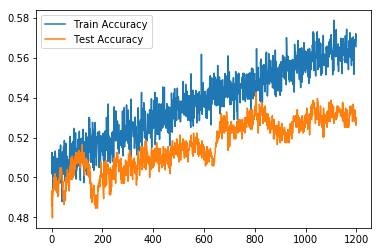

In [138]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

plt.plot(accuracy, label = "Train Accuracy")
plt.plot(val_accuracy, label = "Test Accuracy")
plt.legend()
plt.show()